In [ ]:
from collections.abc import Sequence
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
import sklearn.feature_extraction.text as sk_text

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os

import random



# Set the desired TensorFlow output level for this example
# tf.logging.set_verbosity(tf.logging.ERROR)


In [ ]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

In [ ]:
"""path = "/content/drive/MyDrive/yelp_dataset/"
    
filename = os.path.join(path,"business_data.csv")    
dfb = pd.read_csv(filename, na_values=['NA', '?'])


removeLessThan20 = dfb[dfb['review_count'] < 20].index
dfb.drop(removeLessThan20, inplace=True)
dfb[0:3]"""

'path = "/content/drive/MyDrive/yelp_dataset/"\n    \nfilename = os.path.join(path,"business_data.csv")    \ndfb = pd.read_csv(filename, na_values=[\'NA\', \'?\'])\n\n\nremoveLessThan20 = dfb[dfb[\'review_count\'] < 20].index\ndfb.drop(removeLessThan20, inplace=True)\ndfb[0:3]'

In [ ]:
"""path = "/content/drive/MyDrive/yelp_dataset/"

filename = os.path.join(path, "reviews_merged.csv")
df_b = pd.read_csv(filename)

df_b"""

'path = "/content/drive/MyDrive/yelp_dataset/"\n\nfilename = os.path.join(path, "reviews_merged.csv")\ndf_b = pd.read_csv(filename)\n\ndf_b'

In [ ]:
"""merged_df = pd.merge(df_b, dfb, on='business_id')
merged_df[0:5]"""

"merged_df = pd.merge(df_b, dfb, on='business_id')\nmerged_df[0:5]"

In [ ]:
"""merged_df.to_csv(r'/content/drive/MyDrive/yelp_dataset/merged_business_and_review.csv', index = False)"""

"merged_df.to_csv(r'/content/drive/MyDrive/yelp_dataset/merged_business_and_review.csv', index = False)"

In [ ]:
"""merged_df[12345:12348]"""

'merged_df[12345:12348]'

In [ ]:
"""path = "/content/drive/MyDrive/yelp_dataset/"
    
filename = os.path.join(path,"merged_business_and_review.csv")    
dfa = pd.read_csv(filename)

dfa.drop(['business_id', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'is_open', 'hours', 'attributes', 'categories'], axis=1, inplace=True)
dfa[0:3]"""

'path = "/content/drive/MyDrive/yelp_dataset/"\n    \nfilename = os.path.join(path,"merged_business_and_review.csv")    \ndfa = pd.read_csv(filename)\n\ndfa.drop([\'business_id\', \'address\', \'city\', \'state\', \'postal_code\', \'latitude\', \'longitude\', \'is_open\', \'hours\', \'attributes\', \'categories\'], axis=1, inplace=True)\ndfa[0:3]'

In [ ]:
"""dfa.to_csv(r'/content/drive/MyDrive/yelp_dataset/transformed_data.csv', index = False)"""

"dfa.to_csv(r'/content/drive/MyDrive/yelp_dataset/transformed_data.csv', index = False)"

In [ ]:
path = '/content/drive/MyDrive/yelp_dataset/'
filename_read = os.path.join(path, 'transformed_data.csv')
df = pd.read_csv(filename_read, na_values=['NA', '?'])
df.drop(['business_id', 'attributes', 'categories'], axis=1, inplace=True)

In [ ]:
data_lite = df[:-51919]
business_names = data_lite['name']
data_lite.drop(['name'], axis=1, inplace=True)
data_lite

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,all_reviews,stars,review_count
0,"b""Ate here for the 1st time on Saturday 08/07/...",4.5,24
1,"b'Took me for 40 bucks through grubhub, no cal...",3.0,27
2,b'I loved this!!!! I was set up on a blind dat...,5.0,29
3,b'What a great neighborhood place to wine it u...,4.5,23
4,"b""This is my go to car wash establishment. Tod...",3.5,40
...,...,...,...
9995,"b""Try the pepperoni and bacon pizza, OMG!! I'v...",3.0,21
9996,b'Love SK NAILS...and Kim does a fantastic job...,3.5,23
9997,"b""Took my dog in after she scratched her eye o...",4.5,63
9998,b'Previously had trouble recognizing high qual...,4.0,106


In [ ]:
vectorizer = sk_text.TfidfVectorizer(max_features=2450, min_df=2, strip_accents='ascii')
matrix = vectorizer.fit_transform(data_lite['all_reviews'])



In [ ]:
tfidf_data = matrix.toarray()
#print(tfidf_data.shape)
#print(vectorizer.get_feature_names())
#print(len(vectorizer.get_feature_names()))
#'x81', 'x82', 'x83', 'x8b', 'xad', 'xbbl', 'xbc', 'xe3', 'xe4', 'xe5', 'xe6', 'xe7', 'xe8', 'xe9'

data_1 = tfidf_data
df_1 = pd.DataFrame(data=data_1, columns=vectorizer.get_feature_names_out())
df_1.drop(['x81', 'xe3'], axis=1, inplace=True)

In [ ]:
data_lite2 = pd.merge(df_1, data_lite, left_index=True, right_index=True)
data_lite2.drop('all_reviews', axis=1, inplace=True)
data_lite2

,00,10,100,11,12,13,14,15,16,17,...,york,you,young,your,yourself,yum,yummy,zero,stars_y,review_count
0,0.000000,0.007720,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,...,0.000000,0.034072,0.011467,0.020651,0.000000,0.014885,0.000000,0.000000,4.5,24
1,0.007556,0.015220,0.000000,0.000000,0.000000,0.010139,0.0,0.017987,0.00000,0.0,...,0.000000,0.076126,0.000000,0.013570,0.007145,0.000000,0.008107,0.000000,3.0,27
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.009056,0.0,0.000000,0.00000,0.0,...,0.000000,0.163996,0.000000,0.016162,0.006382,0.000000,0.000000,0.000000,5.0,29
3,0.000000,0.013522,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,...,0.000000,0.089513,0.000000,0.030140,0.000000,0.000000,0.000000,0.000000,4.5,23
4,0.000000,0.009017,0.000000,0.004719,0.000000,0.000000,0.0,0.017761,0.01211,0.0,...,0.000000,0.079589,0.000000,0.050918,0.000000,0.000000,0.000000,0.021262,3.5,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000000,0.005911,0.000000,0.000000,0.000000,0.000000,0.0,0.006986,0.00000,0.0,...,0.000000,0.020870,0.008779,0.026352,0.000000,0.034189,0.000000,0.000000,3.0,21
9996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,...,0.000000,0.092312,0.000000,0.031083,0.000000,0.000000,0.000000,0.000000,3.5,23
9997,0.000000,0.000000,0.000000,0.000000,0.002748,0.003909,0.0,0.004624,0.00000,0.0,...,0.000000,0.069063,0.002905,0.034882,0.002755,0.000000,0.000000,0.000000,4.5,63
9998,0.001808,0.006068,0.003755,0.000953,0.003410,0.000000,0.0,0.003586,0.00000,0.0,...,0.001482,0.102834,0.000000,0.016772,0.001709,0.000000,0.002909,0.000000,4.0,106


In [ ]:
#tfidf_data = tfidf_data.to_numpy()
x, y = to_xy(data_lite2, "stars_y")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42) 

print(x.shape)
print(y.shape)

(10000, 2449)
(10000,)


In [ ]:
# Low neuron count and one hidden layer: RMSE score between 0.47 and 0.38

"""checkpointer_m1 = ModelCheckpoint(filepath="/content/drive/MyDrive/yelp_dataset/dnn/best_weights_prev_models.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(22, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_m1],verbose=2,epochs=100)

model.load_weights('/content/drive/MyDrive/yelp_dataset/dnn/best_weights.hdf5')"""

In [ ]:
# High neuron count and three hidden layers, SGD optimizer: RMSE score between 0.58 and 0.45

"""checkpointer_m2 = ModelCheckpoint(filepath="/content/drive/MyDrive/yelp_dataset/dnn/best_weights_prev_models.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(550, input_dim=x.shape[1], activation='sigmoid'))
    model.add(Dense(90, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='SGD')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_m2],verbose=2,epochs=100)

model.load_weights('/content/drive/MyDrive/yelp_dataset/dnn/best_weights.hdf5')"""

In [ ]:
# Low neuron count and two hidden layers, SGD optimizer: RMSE score around 0.84

checkpointer_m3 = ModelCheckpoint(filepath="/content/drive/MyDrive/yelp_dataset/dnn/best_weights_prev_models.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(2):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(30, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(10, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='SGD')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=15, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer_m3],verbose=2,epochs=100)

model.load_weights('/content/drive/MyDrive/yelp_dataset/dnn/best_weights.hdf5')



In [ ]:
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/yelp_dataset/dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(12, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=7, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

model.load_weights('/content/drive/MyDrive/yelp_dataset/dnn/best_weights.hdf5')



0
Epoch 1/100
250/250 - 1s - loss: 4.3824 - val_loss: 0.7984 - 1s/epoch - 6ms/step
Epoch 2/100
250/250 - 1s - loss: 0.6261 - val_loss: 0.4552 - 778ms/epoch - 3ms/step
Epoch 3/100
250/250 - 1s - loss: 0.3235 - val_loss: 0.2114 - 725ms/epoch - 3ms/step
Epoch 4/100
250/250 - 1s - loss: 0.1735 - val_loss: 0.1741 - 736ms/epoch - 3ms/step
Epoch 5/100
250/250 - 1s - loss: 0.1419 - val_loss: 0.1453 - 816ms/epoch - 3ms/step
Epoch 6/100
250/250 - 1s - loss: 0.1262 - val_loss: 0.1436 - 774ms/epoch - 3ms/step
Epoch 7/100
250/250 - 1s - loss: 0.1017 - val_loss: 0.1129 - 772ms/epoch - 3ms/step
Epoch 8/100
250/250 - 1s - loss: 0.2565 - val_loss: 0.2902 - 693ms/epoch - 3ms/step
Epoch 9/100
250/250 - 1s - loss: 0.1143 - val_loss: 0.1242 - 637ms/epoch - 3ms/step
Epoch 10/100
250/250 - 1s - loss: 0.0905 - val_loss: 0.1061 - 722ms/epoch - 3ms/step
Epoch 11/100
250/250 - 1s - loss: 0.0908 - val_loss: 0.1180 - 748ms/epoch - 3ms/step
Epoch 12/100
250/250 - 1s - loss: 0.0926 - val_loss: 0.1003 - 1s/epoch - 5m

Final score (RMSE): 0.8407665491104126


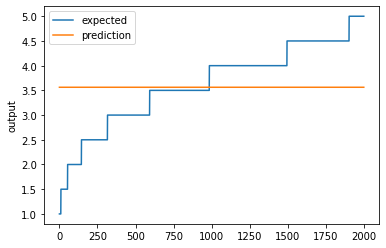

In [ ]:
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))
chart_regression(pred.flatten(), y_test, sort=True)

In [ ]:
b1, b2, b3, b4, b5 = random.sample(range(0, 1999), 5)
print("{}. Business name: {} || Actual stars: {} || Predicted stars: {}".format(1,business_names[b1],y_test[b1],pred[b1]))
print("{}. Business name: {} || Actual stars {} || Predicted stars: {}".format(2,business_names[b2],y_test[b2],pred[b2]))
print("{}. Business name: {} || Actual stars: {} || Predicted stars: {}".format(3,business_names[b3],y_test[b3],pred[b3]))
print("{}. Business name: {} || Actual stars: {} || Predicted stars: {}".format(4,business_names[b4],y_test[b4],pred[b4]))
print("{}. Business name: {} || Actual stars: {} || Predicted stars: {}".format(5,business_names[b5],y_test[b5],pred[b5]))

1. Business name: Gandolfos New York Deli || Actual stars: 3.5 || Predicted stars: [3.557754]
2. Business name: Studio Goddess || Actual stars 3.0 || Predicted stars: [2.8373337]
3. Business name: Mister Car Wash || Actual stars: 2.5 || Predicted stars: [2.7861786]
4. Business name: Renaud's Patisserie & Bistro || Actual stars: 3.5 || Predicted stars: [3.3707643]
5. Business name: Pathmark || Actual stars: 2.5 || Predicted stars: [2.5683112]
